In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_excel('Final_twitter.xlsx')

FileNotFoundError: [Errno 2] No such file or directory: 'Final_twitter.xlsx'

In [ ]:
df.shape

In [ ]:
df.drop(columns='Unnamed: 0', inplace=True)

In [3]:
df.head()

NameError: name 'df' is not defined

In [6]:
df.tail()

,post,label,reading_score,processed_post,emojis,mentions,caps,tokens,num_tokens,chars,...,disgust,surprise,neutral,anger,sad,happy,fear,labels_num,urls,avg_word_length
19547,Bec she didn't want her kids to think it was,#WhyILeft,103.63,Bec she didn't want her kids to think it was,0,0,0.029412,bec want kid,3,45,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,4.090909
19548,"If a guy asks questions, something is up with ...",#WhyILeft,85.69,"If a guy asks questions, something is up with ...",0,0,0.025641,guy asks question something,4,51,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,5.100000
19549,: university options 4. Me,#WhyILeft,33.58,: university options 4. Me,0,0,0.052632,university option,2,27,...,0.004464,0.031250,0.004464,0.040179,0.040179,0.004464,0.040179,0,0,9.000000
19550,"#WhyIStayed my friends tried to intervene, but...",#WhyIStayed,63.02,"my friends tried to intervene, but I wasnt re...",0,0,0.019231,friend tried intervene wasnt ready b saved eve...,15,133,...,0.018123,0.024111,0.005226,0.026555,0.057947,0.022623,0.014403,1,0,5.320000
19551,I stayed because my pastor told me that God ha...,#WhyIStayed,85.18,I stayed because my pastor told me that God ha...,0,0,0.044944,stayed pastor god hate divorce cross mind god ...,11,115,...,0.000628,0.018005,0.015299,0.043888,0.009210,0.039747,0.016748,1,0,5.000000


In [7]:
df.shape

(19552, 23)

In [8]:
df.label.value_counts()

#WhyIStayed    13731
#WhyILeft       5821
Name: label, dtype: int64

# Modeling

In [9]:
models=pd.DataFrame(index=['Naive Bayes Classifier', 'Random Forest Classifier', 'Logistic Regression'],\
                    columns=['Best min_df for CountVectorizer', 'Best Parameters', 'ROC AUC Score'])

## Naive Bayes Classifier

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve

In [11]:
def pick_min_df(X, y, min_df_range=20, clf='nb'):
    X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=123)
    pick_df=pd.DataFrame({}, columns=['test_accuracy'])
    for i in range(min_df_range):
        vect=CountVectorizer(min_df=i)
        #dtm: document-term matrix
        X_train_dtm=vect.fit_transform(X_train)
        X_test_dtm=vect.transform(X_test)
        if clf=='nb':
            clf=MultinomialNB()
        elif clf=='rfc':
            clf=RandomForestClassifier(random_state=123)
        elif clf=='lr':
            clf=LogisticRegression(random_state=123)
        clf.fit(X_train_dtm, y_train)
        y_pred=clf.predict(X_test_dtm)
        y_pred_prob=clf.predict_proba(X_test_dtm)[:,1]
        pick_df=pd.concat([pick_df, pd.DataFrame({'test_accuracy':[roc_auc_score(y_test, y_pred_prob)]})])
    pick_df=pick_df.reset_index(drop=True)
    
    return pick_df[pick_df['test_accuracy']==max(pick_df['test_accuracy'])]



In [12]:
pick_min_df(df.tokens, df.labels_num)

,test_accuracy
0,0.824254
1,0.824254


In [13]:
X_train, X_test, y_train, y_test=train_test_split(df.tokens, df.labels_num, test_size=0.2, random_state=123)
vect=CountVectorizer(min_df=1)
X_train_dtm=vect.fit_transform(X_train)
X_test_dtm=vect.transform(X_test)
nb=MultinomialNB()
nb.fit(X_train_dtm, y_train)
y_pred=nb.predict(X_test_dtm)
y_pred_prob=nb.predict_proba(X_test_dtm)[:,1]

In [14]:
roc_auc_score(y_test, y_pred_prob) #same as nb.score(X_test_dtm,y_test)

0.82425354163959

In [15]:
from sklearn.model_selection import GridSearchCV
param_grid={'alpha':[.001, .01, .1, 1, 5, 10, 50, 100, 1000]}
nb_cv=GridSearchCV(nb, param_grid, scoring='roc_auc', cv=5)
nb_cv.fit(X_train_dtm, y_train)
print("Tuned Naive Bayes Parameter: {}".format(nb_cv.best_params_))
print("Tuned Naive Bayes ROC_AUC Score: {}".format(nb_cv.best_score_))

Tuned Naive Bayes Parameter: {'alpha': 1}
Tuned Naive Bayes ROC_AUC Score: 0.8070528911631865


In [16]:
models['Best min_df for CountVectorizer'][0]=1
models['Best Parameters'][0]=nb_cv.best_params_

In [17]:
X_train, X_test, y_train, y_test=train_test_split(df.tokens, df.labels_num, test_size=0.2, random_state=123)
vect=CountVectorizer(min_df=1)
X_train_dtm=vect.fit_transform(X_train)
X_test_dtm=vect.transform(X_test)
nb=MultinomialNB(alpha=1)
nb.fit(X_train_dtm, y_train)
y_pred=nb.predict(X_test_dtm)
y_pred_prob=nb.predict_proba(X_test_dtm)[:,1]
nb_fpr, nb_tpr, nb_thresholds=roc_curve(y_test, y_pred_prob)
models['ROC AUC Score'][0]=roc_auc_score(y_test, y_pred_prob)

## Random Forest Classifier

In [18]:
pick_min_df(df.tokens, df.labels_num, clf='rfc')

,test_accuracy
9,0.806089


In [19]:
models['Best min_df for CountVectorizer'][1]=9

In [20]:
X_train, X_test, y_train, y_test=train_test_split(df.tokens, df.labels_num, test_size=0.2, random_state=123)
vect=CountVectorizer(min_df=9)
X_train_dtm=vect.fit_transform(X_train)
X_test_dtm=vect.transform(X_test)
rfc=RandomForestClassifier(random_state=123)
rfc.fit(X_train_dtm, y_train)
y_pred=rfc.predict(X_test_dtm)
y_pred_prob=rfc.predict_proba(X_test_dtm)[:,1]

In [21]:
roc_auc_score(y_test, y_pred_prob)

0.8060891800011722

In [22]:
param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 1, 3, 5, 7, 15, 30],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [10, 50, 100, 300, 700, 1000]}

rfc_cv=GridSearchCV(rfc, param_grid, scoring='roc_auc', cv=5)
rfc_cv.fit(X_train_dtm, y_train)
print("Tuned Random Forest Classifier Parameter: {}".format(rfc_cv.best_params_))
print("Tuned Random Forest Classifier ROC_AUC Score: {}".format(rfc_cv.best_score_))

KeyboardInterrupt: 

In [ ]:
models['Best Parameters'][1]=rfc_cv.best_params_

In [ ]:
X_train, X_test, y_train, y_test=train_test_split(df.tokens, df.labels_num, test_size=0.2, random_state=123)
vect=CountVectorizer(min_df=9)
X_train_dtm=vect.fit_transform(X_train)
X_test_dtm=vect.transform(X_test)
rfc=RandomForestClassifier(random_state=123, criterion='entropy', max_depth=30, max_features='log2', n_estimators=1000)
rfc.fit(X_train_dtm, y_train)
y_pred=rfc.predict(X_test_dtm)
y_pred_prob=rfc.predict_proba(X_test_dtm)[:,1]
rfc_fpr, rfc_tpr, rfc_thresholds = roc_curve(y_test, y_pred_prob) 

In [ ]:
models['ROC AUC Score'][1]=roc_auc_score(y_test, y_pred_prob)

## Logistic Regression

In [ ]:
pick_min_df(df.tokens, df.labels_num, clf='lr')

In [ ]:
models['Best min_df for CountVectorizer'][2]=1

In [ ]:
X_train, X_test, y_train, y_test=train_test_split(df.tokens, df.labels_num, test_size=0.2, random_state=123)
vect=CountVectorizer(min_df=1)
X_train_dtm=vect.fit_transform(X_train)
X_test_dtm=vect.transform(X_test)
lr=LogisticRegression(random_state=123)
lr.fit(X_train_dtm, y_train)
y_pred=lr.predict(X_test_dtm)
y_pred_prob=lr.predict_proba(X_test_dtm)[:,1]

In [ ]:
roc_auc_score(y_test, y_pred_prob) 

In [ ]:
param_grid={'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000]}
lr_cv=GridSearchCV(lr, param_grid, scoring='roc_auc', cv=5)
lr_cv.fit(X_train_dtm, y_train)
print("Tuned Logistic Regression Parameter: {}".format(lr_cv.best_params_))
print("Tuned Logistic Regression ROC_AUC Score: {}".format(lr_cv.best_score_))

In [ ]:
models['Best Parameters'][2]=lr_cv.best_params_

In [ ]:
X_train, X_test, y_train, y_test=train_test_split(df.tokens, df.labels_num, test_size=0.2, random_state=123)
vect=CountVectorizer(min_df=1)
X_train_dtm=vect.fit_transform(X_train)
X_test_dtm=vect.transform(X_test)
lr=LogisticRegression(random_state=123, C=1)
lr.fit(X_train_dtm, y_train)
y_pred=lr.predict(X_test_dtm)
y_pred_prob=lr.predict_proba(X_test_dtm)[:,1]
lr_fpr, lr_tpr, lr_thresholds = roc_curve(y_test, y_pred_prob) 

In [ ]:
models['ROC AUC Score'][2]=roc_auc_score(y_test, y_pred_prob)

In [ ]:
pd.set_option('display.max_colwidth', None)
models

In [ ]:
plt.plot([0,1],[0,1],'k--')
plt.plot(nb_fpr, nb_tpr, label='Naive Bayes Classifier') 
plt.plot(rfc_fpr, rfc_tpr, label='Random Forest Classifier') 
plt.plot(lr_fpr, lr_tpr, label='Logistic Regression') 
plt.grid()
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC Curve') 
plt.show()

# Feature Importances: Most Predictive Words

In [23]:
from sklearn.metrics import roc_curve, precision_recall_curve, fbeta_score, ConfusionMatrixDisplay, classification_report, confusion_matrix

In [24]:
X_train, X_test, y_train, y_test=train_test_split(df.tokens, df.labels_num, test_size=0.2, random_state=123)
vect=CountVectorizer(min_df=1)
X_train_dtm=vect.fit_transform(X_train)
X_test_dtm=vect.transform(X_test)
lr=LogisticRegression(random_state=123, C=1)
lr.fit(X_train_dtm, y_train)
y_pred=lr.predict(X_test_dtm)
y_pred_prob=lr.predict_proba(X_test_dtm)[:,1]
lr_fpr, lr_tpr, lr_thresholds = roc_curve(y_test, y_pred_prob) 

In [25]:
roc_auc_score(y_test, y_pred_prob)

0.8288739510146457

In [26]:
features = np.array(vect.get_feature_names_out())

x = np.eye(X_test_dtm.shape[1])
probs = lr.predict_log_proba(x)[:, 0] #using log is more precise for lower probabilities
ind = np.argsort(probs)

words = pd.DataFrame({})

words['word']=features[ind]
words['prob']=1-np.exp(probs[ind])

words.head(20)

,word,prob
0,nowhere,0.934345
1,believed,0.917359
2,convinced,0.910508
3,isolated,0.899940
4,brainwashed,0.892029
5,admit,0.891917
6,embarrassed,0.891530
7,fault,0.891363
8,shock,0.884665
9,petrified,0.884183


In [27]:
words.tail(20)

,word,prob
8531,terrorized,0.277049
8532,mirror,0.270864
8533,opportunity,0.268306
8534,appeal,0.265841
8535,longer,0.261093
8536,woke,0.257867
8537,met,0.256681
8538,mommy,0.249751
8539,verbally,0.245463
8540,daughter,0.237025


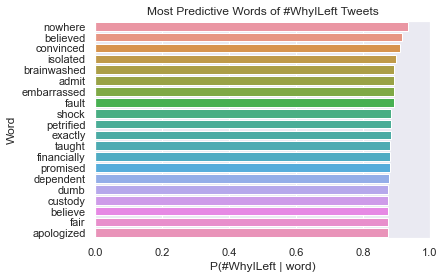

In [28]:
sns.set(rc={'figure.figsize':(10,8)})
ax=sns.barplot(x=words.prob[:20], y=words.word[:20])
ax.set(xlim=(0.0,1.0),xlabel='P(#WhyILeft | word)', ylabel='Word', title='Most Predictive Words of #WhyILeft Tweets')
plt.show();

## Self Empowerment

*Discovered, realized, decided, inability, and motivated* describe both gradual and sudden moments of breaking out of learned helplessness through self-empowerment.

In [29]:
df.post[127] #realized

'"@ravenmundy: #whyileft Because I realized someone had to actually love me, even if it was only myself."  Wow! #truth'

In [30]:
df.post[19343] #tired

'#whyileft I left him because I had enough with the insults and the threats and the empty demonstrations of so called love. I was tired.'

In [31]:
df.post[1771] #decided

'#whyileft because I woke up one morning and decided to take my power back. I needed to set an example for my kids abuse is not acceptable!!'

In [32]:
df.post[7865] #discovered

'I discovered one day that I was powerful and beautiful, that my friends loved me. #WhyILeft'

In [33]:
df.post[4632] #woke

'#WhyILeft  I woke up and realised that no one could possibly deserve it... especially not the children.'

## Descriptions of Abuse

*Table, chased, kitchen, snuck, and pulling* are contained in often graphic tweets describing physical abuse.

In [34]:
df.post[9861] #mirror #verbal

'@WhyIStayed When the many shades of verbal abuse bruises began to show in the mirror #WhyILeft'

In [35]:
df.post[18946] #mirror

" I couldn't look at myself in the mirror anymore. Scars fade but still dealing w/ it 20 yrs on."

In [36]:
df.post[4321] #anymore

"#whyileft My mental and physical health was bottoming out.  I ended up in the hospital.  I couldn't do it anymore even if I loved him."

In [37]:
df.post[12524] #biological

'I left my biological family because I WAS NEVER LOVED BY THEM, NEVER EVER, I WAS USED AND ABUSED AND EVEN RAPED BY THEM #WhyILeft'

In [38]:
df.post[695] #finally

"#WhyILeft - Because I finally saw the light leave his eyes in the act. That's when I believed he wouldn't stop until he killed me."

In [39]:
df.post[13086] #anymore

"#whyileft i'll say it again.  i left him because i didn't love him anymore after he tried to choke (kill) me.  he also tried to kill my cat."

In [40]:
df.post[1321] #terrorized

' He broke my nose, totally terrorized me after and threatened to kill my parents.'

## Outside Intervention

** is used to describehow outside influences such as family, friends, and new relationships intervened with the situation.

In [41]:
df.post[2577] #opportunity

'#WhyILeft My now-wife gave me the courage and opportunity to leave.'

In [42]:
df.post[959] #met

'I was finally able to break the isolation, met people who empowered me to see that I deserved better. They changed my worldview #whyileft'

In [43]:
df.post[18346] #fled

'I left because I had the support of my mother, who immediately let me move back home after I fled once he fell asleep. #whyileft'

In [44]:
df.post[85] #finally

'#whyileft good friends helped me finally see that I deserve better'

In [45]:
df.post[2132] #reached

'#WhyILeft is good, kind people reached out to me and helped me when I needed it the most.'

In [46]:
df.post[3777] #reached

'#whyileft An old friend reached out, showed me that I was not alone, and helped me find a way out.'

In [47]:
df.post[14918] #reached

"Although everyone knew, one of his friends reached out to me and told me that it wasn't my fault and that I deserved to be safe.  #WhyILeft"

## Children

*Mommy* tweets expressed love and empathy for the children in the family. Seeing how the children were affected by the abuse aided in the decision to leave, in order to gain control of the environment they were growing up in.

In [48]:
df.post[41] #opportunity

'To give my son the fair opportunity to learn to respect women, mothers, and me. And because I love him. #WhyILeft http://t.co/t3LRhoNkVl'

In [49]:
df.post[944] #finally

'#whyileft my son refusing to go to school cos "daddy hits mommy" was the last straw. I finally saw it through his eyes. Near death. Twice'

In [50]:
df.post[13939] #daughter #verbally

'I didn\'t want my daughter growing up thinking it was "normal" for your husband to abuse you verbally and physically #WhyILeft'

In [51]:
df.post[18715] #longer

'#WhyILeft I finally found the word No once I had kids - they made me stay longer at first, but seeing the wrong with their eyes opened mine.'

In [52]:
df.post[150] #daughter

"when he kicked my daughter in the stomach and said he'd put a bullet through my head, i knew it wasn't getting better. #WhyILeft"

# Feature Importances: Least Predictive Words

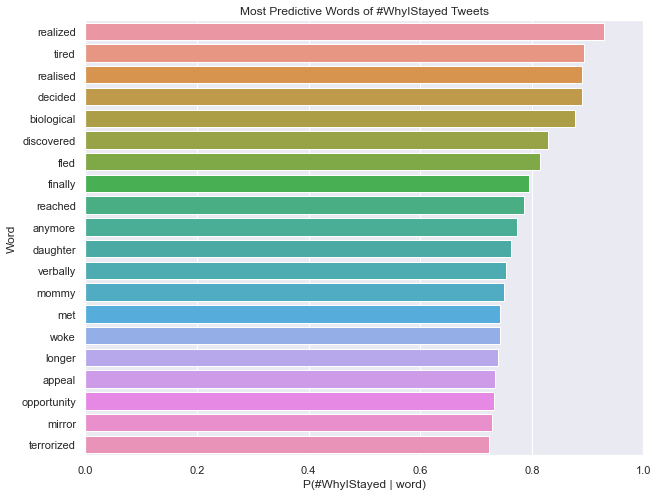

In [53]:
sns.set(rc={'figure.figsize':(10,8)})
ax=sns.barplot(x=1-words.sort_values(by='prob', ascending=True).prob[:20], y=words.sort_values(by='prob', ascending=True).word[:20])
ax.set(xlim=(0.0,1.0),xlabel='P(#WhyIStayed | word)', ylabel='Word', title='Most Predictive Words of #WhyIStayed Tweets')
plt.show();

## Psychological Dependency (Low Self-Worth/Gaslighting)

*Dumb, brainwashed, dependent* and *syndrome* refer to the erosion of self-worth through repeated exposure to name-calling and criticism. Insecure attachment to the abusive partner is described in these tweets.

In [54]:
df.post[19515] #believed

'Because he told me that no one would else would ever want me &amp; claimed that I belonged to him. I was scared, so I believed him. #WhyIStayed'

In [55]:
df.post[201] #convinced

'#WhyIStayed he convinced me I was stupid, less desirable than other women and that *he* did me a favor by being with me because of my PTSD.'

In [56]:
df.post[18820] #isolated

'He slowly started verbally abusing me, destroying self-esteem I had &amp; isolated me from friends &amp; family before ever hitting me #whyistayed'

In [57]:
df.post[185] #fault

"I had been conditioned to think it was my fault. Had to figure out it wasn't me and I had no reason to stay. #WhyIStayed"

In [58]:
df.post[8809] #exactly

"because he repeatedly told me that all guys were exactly like him and I couldn't do any better. #WhyIStayed"

In [59]:
df.post[7924] #dependent #believe

'#WhyIStayed I felt dependent on him. After you are told and treated like you are worthless repetitively enough you start to believe it.'

In [60]:
df.post[4147] #dumb #believe

'#WhyIStayed because when you hear "you\'re dumb, worthless, ugly" daily for 1 year you begin to believe it so much you stay a 2nd year'

## Lack of Validation & History of Family Violence

*Believed*, *convinced*, and *dumb* were features for lack of social validation. Some of these tweets describe victims turning a blind eye to emotional and verbal abuse because there was no physical abuse.

In [61]:
df.post[15456] #fault

"let's not forget that some women convince abused women that the abuse they are suffering is own their fault...society is sick! #WhyIStayed"

In [62]:
df.post[17850] #believed

'Because we live in a society that blames victims, and I believed it was my fault for a long time. #WhyIStayed'

In [63]:
df.post[16] #believed

'#WhyIStayed no one believed it was as bad as it was even after all the frequent er visits'

In [64]:
df.post[7271] #believed

"#WhyIStayed Because I've been told all my life that a man's only worth is in how he supports and protects women, and I foolishly believed it"

In [65]:
df.post[727] #believed

'#WhyIStayed My parents hit me &amp; said they loved me. So when he hit me &amp; said he loved me I believed him.'

In [66]:
df.post[3439] #believed

'The abuse felt normal (like my childhood) I believed I was lucky that anyone would even want me and he made that clear. #WhyIStayed'

In [67]:
df.post[12984] #convinced

'His mom convinced me to stay. Her need for s/one to babysit her son was greater than my safety. Even after she knew he beat me. #WhyIStayed'

In [68]:
df.post[4731] #convinced

"I stayed because I convinced myself verbal abuse wasn't that bad if it didn't turn physical &amp; he said no one else would want me. #WhyIStayed"

In [69]:
df.post[2624] #dumb

'Bc when it got even worse my best friend at the time blamed me for being so weak so dumb so stupid #WhyIStayed'

In [70]:
df.post[19097] #dumb

'Because my mother said "you were dumb enough to marry him, now you have to suffer the consequences" #WhyIStayed'

## Feelings of Shame

*Embarrassed, shock, dumb*, and *admit* were words that express feelings of shame.

In [71]:
df.post[287] #admit

'#WhyIStayed I was too stubborn to admit that my family was right'

In [72]:
df.post[233] #embarrassed

'The reason #WhyIStayed after he moved his girlfriend in was because I really had no place to go and I was too embarrassed to tell anyone.'

In [73]:
df.post[10702] #embarrassed #shock

"#WhyIStayed because I was embarrassed &amp; shocked it happened. Then thought, in relationship you're supposed to work through problems together"

In [74]:
df.post[9791] #dumb

"Because I was a strong intelligent woman and I didn't want people to know I was dumb enough to let it happen to me. #WhyIStayed"

## Financial, Emotional, and Physical Dependency

*Financially, nowhere*, and *isolated* describe situations where the victim did not have control of her/his own finances and felt socially isolated from loved ones. Many tweets relating to finances recalled experiencing economic abuse, where one partner controls the other partner's ability to acquire, use, and maintain economic resources to prevent victims from leaving the abuser by lack of financial means.

In [75]:
df.post[280] #nowhere

'#WhyIStayed There was no room in the shelter and nowhere else to go.'

In [76]:
df.post[317] #nowhere #convinced

'also "just leaving" becomes irrelevant if you don\'t have the resources/support network to do so. no money. nowhere to go. etc #WhyIStayed'

In [77]:
df.post[12084] #brainwashed

'Being isolated enough to hate my friends, family, and self, while brainwashed into thinking that was how all relationships are #WhyIStayed'

In [78]:
df.post[35] #financially #dependent

"Bcuz it didn't happen overnight, it gradually led up to him abusing me and by then I was emotionally &amp; financially dependent   #WhyIStayed"

In [79]:
df.post[1965] #financally

'#WhyIStayed Not because I depended on him financially, but because it was the other way around.'

In [80]:
df.post[2845] #financially

'#WhyIStayed we worked together, lived together. she controlled me financially, emotionally. she manipulated me into thinking i owed her.'

In [81]:
df.post[6205] #financially

'#WhyIStayed is almost never about the net worth of the abuser. It is often about the abuser having made the victim financially dependent.'

In [82]:
df.post[12402] #financially

'He also made me quit working, made me completely dependent on him, &amp; I realized all too late he had cleaned me out financially. #WhyIStayed'

## Fear of Retaliation

*Fail, nowhere, apologized*, and *believed* are used to describe situations where the abusive partner would use threats against his or her own life, or the author and author's loved ones.

In [83]:
df.post[376] #isolated

'#WhyIStayed Because he told me he would kill me and that no one would ever love me the way he did. I was scared, felt isolated from family.'

In [84]:
df.post[11426] #fault

'#whyistayed because I was afraid he would kill himself and that it would be all my fault. He did, and I am not to blame.'

In [85]:
df.post[15993] #shock

'#WhyIStayed because I was in shock, like a nightmare, then when I gained focus he threatened to kill me.'

In [86]:
df.post[12839] #petrified

'#WhyIStayed I was petrified and thought he would take my daughter. #Why I Left I knew one day he would do the same to my daughter.'

In [87]:
df.post[14847] #custody

'#WhyIStayed because he threatened to kidnap the children or destroy me in a nasty custody battle if i ever left.'

## Children

In [88]:
df.post[12365] #financially

'#WhyIStayed I felt financially trapped even though I knew I could support myself. It was different with a child with special needs though.'

In [89]:
df.post[323] #custody

'Because of the financial burdens of custody battles while still caring for the kids alone monetarily #WhyIStayed'

In [90]:
df.post[12033] #custody

"family court doesn't believe u if u have no proof, so they take your kids away from you, or force you to agree to joint custody #WhyIStayed"

In [91]:
df.post[19271] #fair

'“@Katiebyeager: I thought my daughter deserved a fair shot at a "happy family" #WhyIStayed” same with my son'

In [92]:
df.post[2876] #believed

'#WhyIStayed cuz i believed I needed to give our children a whole family. No matter how miserable I was....I was wrong, left 2 years ago'

## Forgiveness & Hope

*Apologized* points to circumstances where the abusive partner apologized but often did not change their behaviour. *Trauma, believed* and *convinced* posts also demonstrate empathy towards the abuser.

In [93]:
df.post[3617] #apologized

'#WhyIStayed After he was violent, he apologized and was extremely apologetic and loving, until the next blowup.'

In [94]:
df.post[161] #convinced

'#WhyIStayed because I thought things would change, and I convinced myself that everything he called me was right.'

In [95]:
df.post[17411] #shock

"#WhyIStayed ...we were newlyweds,I was shell-shocked,he didn't hit me-it was verbal,he apologized w/shopping,&amp;he said it wasn't verbal abuse"

In [96]:
df.post[18656] #promised #believe

'Because he was always sorry and promised he would change.  And i had to believe him to survive.  #whyistayed'

In [97]:
df.post[1230] #promised #believed

'He said he would change. He promised it was the last time. I believed him. He lied. #WhyIStayed'

In [98]:
df.post[5702] #promised #apologized

'#WhyIStayed he always apologized with gifts and promised it would never happen again. (Or at least until the bruises healed)'

## Religion

Most *Church* tweets contain information about outdated religious views of marriage, as many religions consider divorce to be sinful.

In [99]:
df.post[634] #taught

'#WhyIStayed being a Christian had taught me i had no value without my wife and that it could be "that bad"'

In [100]:
df.post[1621] #fault

'#WhyIStayed Because the elders of our church told my mother and I that it was our fault.'

In [101]:
df.post[13725] #fault

'#WhyIStayed my pastor told me to pray more, fast more, submit more.  I was told by my church it was my fault.  \n\nRC'

## Notable Mentions

### Criticisms of #WhyIStayed

The reason why *society* seems to be the most predictive feature of #WhyIStayed may be partly because *society* is also used to criticize the movement of putting the focus onto victims rather than abusers. 

In [102]:
df.post[4135] #society

'#WhyIStayed: Fear, embarrassment, lack of money, lack of a different place to live (due to lack of money)...'

In [103]:
df[(df.post.str.contains('church'))&(df.label=='#WhyIStayed')].post

111      #WhyIStayed:  How some churches support spousa...
452      New post that focuses on how some churches sup...
723      @unitedchurch let us not judge- let us listen....
769      We had so many mutual friends and he was activ...
1549     B/C 3 years after my MIL finally defied the Ch...
1621     #WhyIStayed Because the elders of our church t...
1775     When I went to the church authorities, they to...
1781      #WhyIStayed because the church told me I had to.
2960         The church said God hated divorce #WhyIStayed
3032     #WhyIStayed because my only option for protect...
3070     My mom had 3 young kids, a mortgage, and a PT ...
3113     #WhyIStayed because the church I attended said...
3283     #WhyIStayed because he knew every place I coul...
3329     @AWiltshire19 I could not be in contct with my...
3705     #WhyIStayed: How some churches support spousal...
3874     A friend of my mom's stayed because our church...
4011     So true......“@ReaganWorld: #WhyIStayed:  How .

In [104]:
df.post[4143] #society

'#WhyIStayed because he threatened to kill himself and blame me in the suicide note if I didn\'t "forget" he shoved me down the stairs'

In [105]:
df.post[4733] #society

"Because he's just trying to keep me out of trouble by not letting me go out w/ certain people. #WhyIStayed #itsnotalwaysphysical"

In [106]:
df.post[7021] #perspective

'#WhyILeft Because what if my sons grew up to be like him?'



*Complicated* helps us look at the other side of this argument that it is indeed important to understand the victim's perspectives in order to ease the victim-blaming.

In [107]:
df.post[19357] #nowhere

'#WhyIStayed I felt I had no other options in life, but to be with him.  My ID was with him, not myself.  #nomore'

In [108]:
df.post[6019] #complicated

"#WhyIStayed he promised he was sorry, he promised he wouldn't do it again, he promised to get help"

In [109]:
df.post[148] #complicated

'#WhyIStayed "@TheAtlantic: For abuse victims, the obstacles to leaving are more complicated than many people think http://t.co/zhJsfoLyfk"'

In [110]:
df.post[12387]

"On average it takes a person 7 tries to leave an abusive relationship.  It is everyone's duty to help lower this to 1. #WhyIStayed"

### Battered Person Syndrome

The keyword *syndrome* returned many tweets alluding to 'battered person syndrome'. Battered woman syndrome, or battered person syndrome, is a psychological condition that can develop when a person experiences abuse, usually at the hands of an intimate partner. These people exhibit four characteristics: They believe the violence is their fault, they can’t place the blame for the violence on anyone else, they fear for their lives and their children’s lives, and they believe their abuser is everywhere and sees everything they do. These symptoms seem to encompass the narratives as seen especially in **2.2.4. Psychological Dependency** and **2.2.5. Fear of Retaliation**. Source: https://www.everydayhealth.com/news/understanding-battered-womens-syndrome/).

In [111]:
df[(df.tokens.str.contains('syndrome'))&(df.label=='#WhyIStayed')].post.values[:5]

array(["#WhyIStayed battered person's syndrome",
       'Battered Person Syndrome and learned helplessness theory help explain why abused spouses often stay in destructive relationships #WhyIStayed',
       '#whyistayed. Cause u need help battered woman syndrome is some real ish. http://t.co/I9FGGk1zwg',
       "I fully understand the abused woman syndrome! I was one. It feels like u can't live without them. Had no self-esteem. #WhyIStayed",
       '@writersrepublic The man is abusive get out of the relationship. That said, I get the concept of the battered women syndrome. #WhyIStayed'],
      dtype=object)

# Thresholding

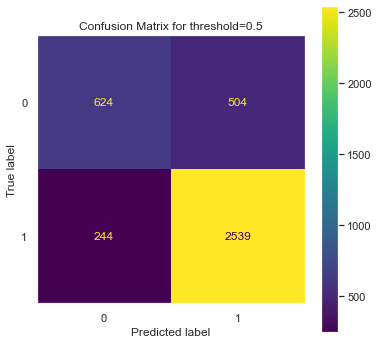

              precision    recall  f1-score   support

           0       0.72      0.55      0.63      1128
           1       0.83      0.91      0.87      2783

    accuracy                           0.81      3911
   macro avg       0.78      0.73      0.75      3911
weighted avg       0.80      0.81      0.80      3911



In [112]:
fthreshold = 0.5

y_pred = (y_pred_prob >= fthreshold).astype('int')
fig, ax = plt.subplots(figsize=(6,6))
cm=confusion_matrix(y_test, y_pred)
disp=ConfusionMatrixDisplay(cm)
disp.plot(ax=ax)
plt.grid(False)
plt.title('Confusion Matrix for threshold='+ str(np.round(fthreshold, 3)))
plt.show()
print(classification_report(y_test, y_pred))

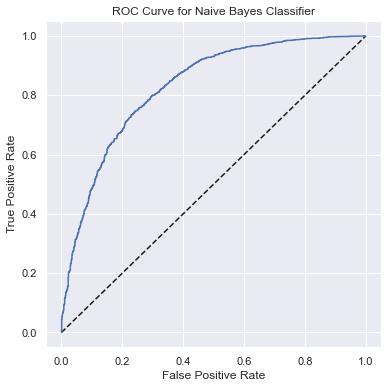

In [113]:
fig, ax=plt.subplots(figsize=(6,6))
ax.plot([0,1],[0,1],'k--')
ax.plot(lr_fpr, lr_tpr) 
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Naive Bayes Classifier') 
plt.show()

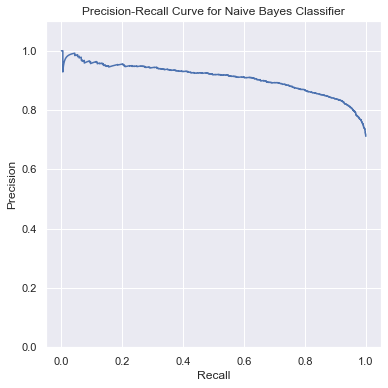

In [114]:
precision, recall, threshold = precision_recall_curve(y_test, y_pred_prob) # pos_labelstr - picks normal weight class
fig, ax=plt.subplots(figsize=(6,6))
ax.plot(recall, precision)
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision-Recall Curve for Naive Bayes Classifier')
ax.set_ylim(0.0, 1.1)
plt.show()

In [115]:
def fbeta_score(precision, recall, beta=1.0):
    return (1+beta**2)*(precision*recall)/((beta**2)*precision+recall)

In [116]:
for i in range(1,6):
    score=fbeta_score(precision, recall, beta=i)
    idx=np.argmax(score)
    print('Beta: '+str(i)+', Threshold: '+str(np.round(threshold[idx], 5))+', F-score: '+str(np.round(score[idx],3)))

Beta: 1, Threshold: 0.39998, F-score: 0.875
Beta: 2, Threshold: 0.13267, F-score: 0.932
Beta: 3, Threshold: 0.07206, F-score: 0.963
Beta: 4, Threshold: 0.0208, F-score: 0.977
Beta: 5, Threshold: 0.00153, F-score: 0.985


In [117]:
fscore=fbeta_score(precision, recall, beta=2)
f_i=np.argmax(fscore)

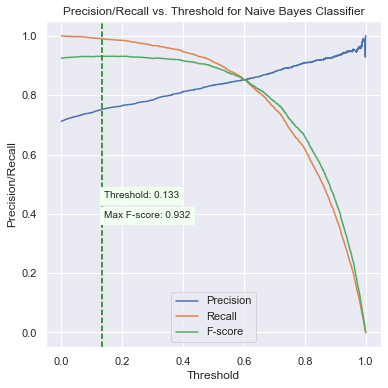

In [118]:
fig, ax=plt.subplots(figsize=(6,6))
ax.plot(threshold, precision[1:], label='Precision')
ax.plot(threshold, recall[1:], label='Recall')

ax.set_xlabel('Threshold')
ax.set_ylabel('Precision/Recall')
ax.set_title('Precision/Recall vs. Threshold for Naive Bayes Classifier')

ax.plot(threshold, fscore[1:], label='F-score')

ax.axvline(threshold[f_i], linestyle='dashed', color='green')
plt.text(threshold[f_i]*1.05, 0.455, 'Threshold: '+str(np.round(threshold[f_i], 3)), fontsize='small', backgroundcolor='honeydew')
plt.text(threshold[f_i]*1.05, 0.385, 'Max F-score: '+str(np.round(fscore[f_i], 3)), fontsize='small', backgroundcolor='honeydew')

ax.legend()
plt.show()

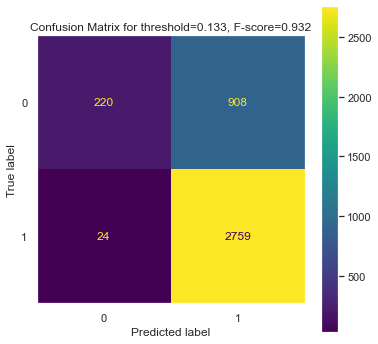

              precision    recall  f1-score   support

           0       0.90      0.20      0.32      1128
           1       0.75      0.99      0.86      2783

    accuracy                           0.76      3911
   macro avg       0.83      0.59      0.59      3911
weighted avg       0.80      0.76      0.70      3911



In [119]:
new_threshold = threshold[f_i]

y_pred = (y_pred_prob >= new_threshold).astype('int')
fig, ax = plt.subplots(figsize=(6,6))
cm=confusion_matrix(y_test, y_pred)
disp=ConfusionMatrixDisplay(cm)
disp.plot(ax=ax)
plt.grid(False)
plt.title('Confusion Matrix for threshold='+ str(np.round(new_threshold, 3))+ ', F-score='+str(np.round(fscore[f_i], 3)))
plt.show()
print(classification_report(y_test, y_pred))

A recall of 0.2 for the #WhyILeft label is too low for this model to be useful. We set a threshold of 0.6 for this number.

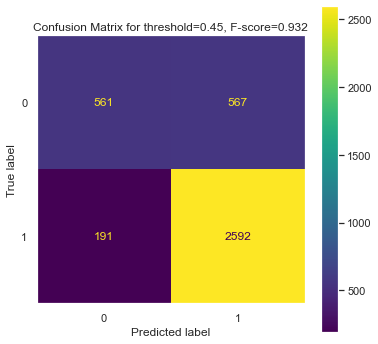

              precision    recall  f1-score   support

           0       0.75      0.50      0.60      1128
           1       0.82      0.93      0.87      2783

    accuracy                           0.81      3911
   macro avg       0.78      0.71      0.73      3911
weighted avg       0.80      0.81      0.79      3911



In [125]:
new_threshold = 0.45

y_pred = (y_pred_prob >= new_threshold).astype('int')
fig, ax = plt.subplots(figsize=(6,6))
cm=confusion_matrix(y_test, y_pred)
disp=ConfusionMatrixDisplay(cm)
disp.plot(ax=ax)
plt.grid(False)
plt.title('Confusion Matrix for threshold='+ str(np.round(new_threshold, 3))+ ', F-score='+str(np.round(fscore[f_i], 3)))
plt.show()
print(classification_report(y_test, y_pred))

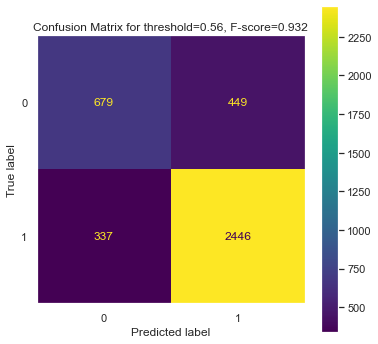

              precision    recall  f1-score   support

           0       0.67      0.60      0.63      1128
           1       0.84      0.88      0.86      2783

    accuracy                           0.80      3911
   macro avg       0.76      0.74      0.75      3911
weighted avg       0.79      0.80      0.80      3911



In [129]:
new_threshold = 0.56

y_pred = (y_pred_prob >= new_threshold).astype('int')
fig, ax = plt.subplots(figsize=(6,6))
cm=confusion_matrix(y_test, y_pred)
disp=ConfusionMatrixDisplay(cm)
disp.plot(ax=ax)
plt.grid(False)
plt.title('Confusion Matrix for threshold='+ str(np.round(new_threshold, 3))+ ', F-score='+str(np.round(fscore[f_i], 3)))
plt.show()
print(classification_report(y_test, y_pred))